In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
from particles import resampling as rs
import sys
sys.path.append('..')

import banana as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/Banana/../utils.py'>

In [2]:
d = 2
sigma = np.sqrt(2)

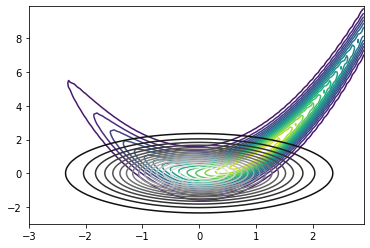

In [3]:
x, y = np.mgrid[-3:3:.1, -3:10:.1]
data = np.dstack((x, y))
z = np.exp(-(sigma**2*(data[:,:, 1]-data[:,:, 0]**2)**2/2+(1-data[:,:, 0])**2/(2*sigma**2)))/(2*np.pi)
zinitial = multivariate_normal.pdf(data, np.array([0, 0]), np.eye(d))
plt.contour(x, y, z, 15)
plt.contour(x, y, zinitial, 15, cmap = 'gray')
# plt.savefig("banana.pdf")

## Algorithms

In [4]:
Niter = 3000
gamma = 0.005
N = 300
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)

Ks = np.array([1, 5, 10, 20, 50])
Ksize = Ks.size

In [5]:
true_sample = np.zeros((N, d))
true_sample[:, 0] = np.random.normal(loc = 1, scale = sigma, size = N)
true_sample[:, 1] = np.random.normal(loc = true_sample[:, 0]**2, scale = 1/sigma, size = N)

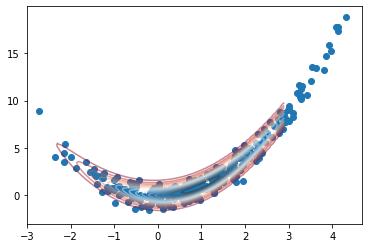

In [6]:
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(true_sample[:,0], true_sample[:,1]);

In [7]:
true_variance = np.cov(true_sample, rowvar = False)

In [8]:
Niter_fr = Niter
Niter_smcula = Niter
Niter_smcmala = Niter

In [9]:
gamma_smcmala = 0.10

In [10]:
Nalgo = 4
Nrep = 10

fr_x = np.zeros((Ksize, Nrep, Niter_fr, d, N))
fr_w = np.zeros((Ksize, Nrep, Niter_fr, N))
wfr_x = np.zeros((Ksize, Nrep, Niter, d, N))
wfr_w = np.zeros((Ksize, Nrep, Niter, N))
smcula_x = np.zeros((Ksize, Nrep, Niter_smcula, d, N))
smcula_w = np.zeros((Ksize ,Nrep, Niter_smcula, N))
smcmala_x = np.zeros((Ksize, Nrep, Niter_smcmala, d, N))
smcmala_w = np.zeros((Ksize, Nrep, Niter_smcmala, N))

runtime = np.zeros((Ksize, Nrep, Nalgo))

In [11]:
for k in range(Ksize):
    nmcmc = Ks[k]
    for i in range(Nrep):
        ## SMC-FR
        start = time.time()
        fr_x[k, i,:], fr_w[k, i,:] = algo.SMC_FR(gamma, Niter_fr, X0, sigma, nmcmc)
        end = time.time()
        runtime[k, i, 0] = end-start
        ### SMC-WFR
        start = time.time()
        wfr_x[k, i,:], wfr_w[k, i,:] = algo.SMC_WFR(gamma, Niter, X0, sigma, nmcmc)
        end = time.time()
        runtime[k, i, 1] = end-start
        ### SMC-ULA
        start = time.time()
        smcula_x[k, i,:], smcula_w[k, i,:] = algo.SMC_ULA(gamma, Niter_smcula, X0, sigma, nmcmc)
        end = time.time()
        runtime[k, i, 2] = end-start
        ### SMC-MALA
        start = time.time()
        smcmala_x[k, i,:], smcmala_w[k, i,:], accepted_smcmala = algo.SMC_MALA(gamma_smcmala, Niter_smcmala, X0, sigma, nmcmc)
        end = time.time()
        runtime[k, i, 3] = end-start

In [12]:
np.mean(np.sum(accepted_smcmala, axis = 0)/Niter_smcmala)

0.5862573696145125

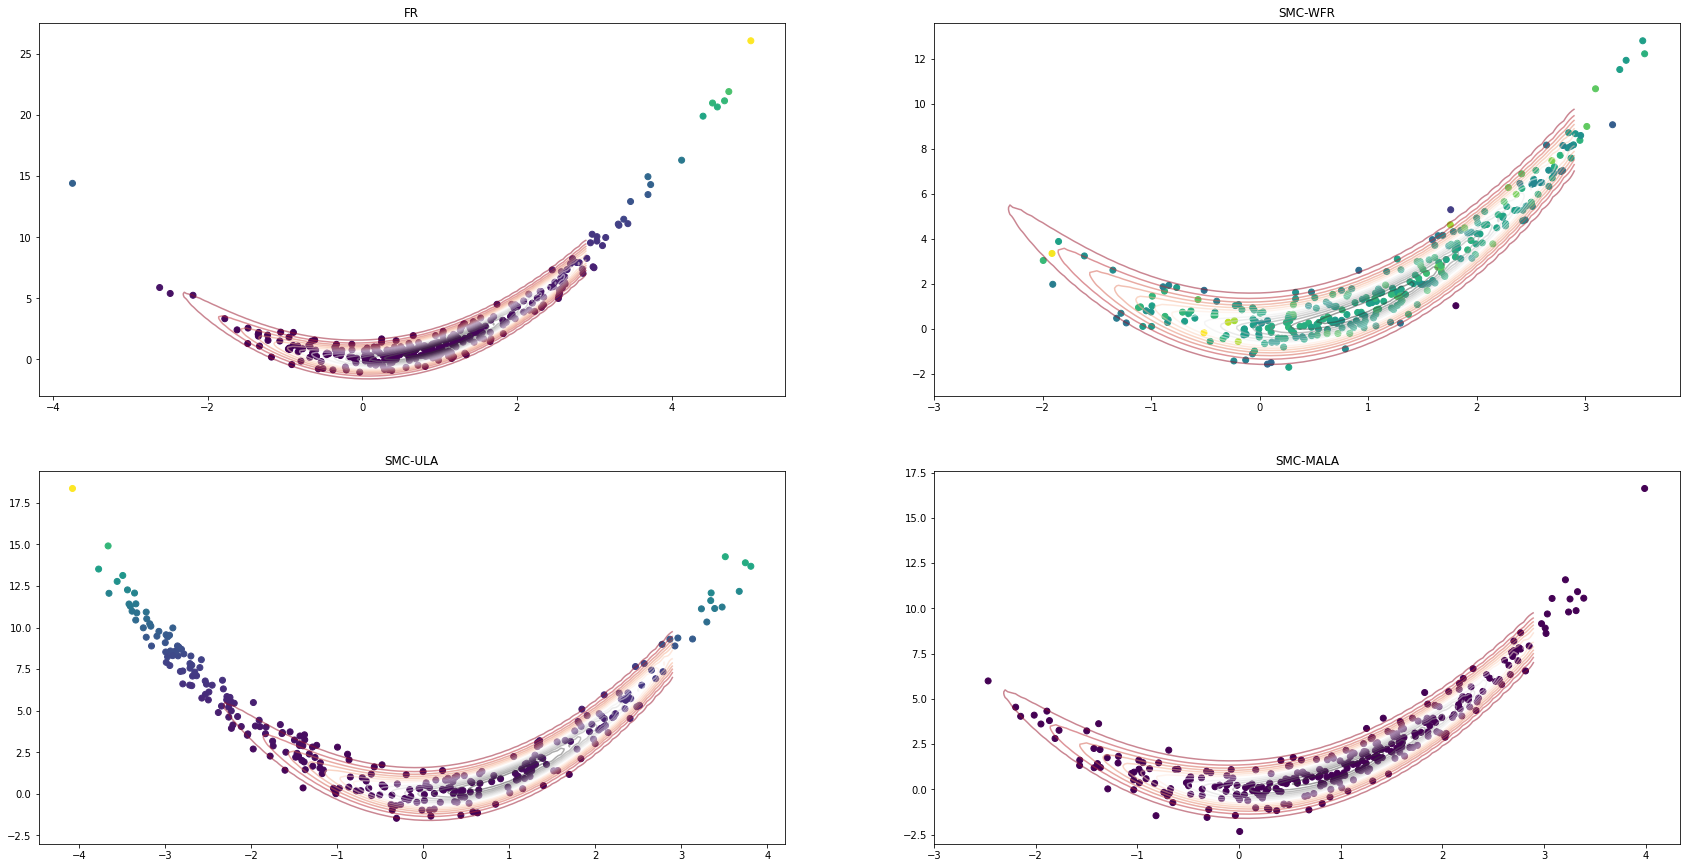

In [13]:
k = 0
i = Nrep-1
plt.figure(figsize = (12,6))
plt.subplot(2, 2, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(fr_x[k, i, -1, 0, :], fr_x[k, i, -1, 1, :], c = fr_w[k, i, -1, :]);
plt.title('FR')
plt.subplot(2, 2, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[k, i, -1, 0, :], wfr_x[k, i, -1, 1, :], c = wfr_w[k, i, -1, :]);
plt.title('SMC-WFR')
plt.subplot(2, 2, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcula_x[k, i, -1, 0, :], smcula_x[k, i, -1, 1, :], c = smcula_w[k, i, -1, :]);
plt.title('SMC-ULA')
plt.subplot(2, 2, 4)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(smcmala_x[k, i, -1, 0, :], smcmala_x[k, i, -1, 1, :], c = smcmala_w[k, i, -1, :]);
plt.title('SMC-MALA')
# plt.colorbar();
plt.subplots_adjust(left=-1,
                    bottom=-1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)
plt.show()

In [14]:
avg_runtime = np.mean(runtime, axis = 1)
avg_runtime

array([[ 1.05172408,  3.97185559,  0.3904093 ,  1.46976967],
       [ 3.15774188,  4.33820732,  0.85475791,  4.6713083 ],
       [ 6.61619005,  5.05590949,  1.57998145,  9.85535719],
       [13.86864922,  6.67799954,  3.0986362 , 21.18226686],
       [36.20533457, 11.18907881,  7.50227051, 54.1296313 ]])

In [15]:
w1_fr = np.zeros((Ksize, Nrep, d, Niter_fr))
w1_wfr = np.zeros((Ksize, Nrep, d, Niter))
w1_smcula = np.zeros((Ksize, Nrep, d, Niter_smcula))
w1_smcmala = np.zeros((Ksize, Nrep, d, Niter_smcmala))

cov_fr = np.zeros((Ksize, Nrep, Niter_fr))
cov_wfr = np.zeros((Ksize, Nrep, Niter))
cov_smcula = np.zeros((Ksize, Nrep, Niter_smcula))
cov_smcmala = np.zeros((Ksize, Nrep, Niter_smcmala))

In [16]:
for h in range(Ksize):
    for j in range(Nrep):
        for i in range(Niter):
            cov_wfr[h, j, i] = np.mean((np.cov(wfr_x[h, j, i, :, :], aweights = wfr_w[h, j, i, :]) - true_variance)**2)
            for k in range(d):
                w1_wfr[h, j, k, i]  = stats.wasserstein_distance(wfr_x[h, j, i, k, :], true_sample[:, k], u_weights = wfr_w[h, j, i, :])
        for i in range(Niter_fr):
            cov_fr[h, j, i] = np.mean((np.cov(fr_x[h, j, i, :, :], aweights = fr_w[h, j, i, :]) - true_variance)**2)
            for k in range(d):
                w1_fr[h, j, k, i]  = stats.wasserstein_distance(fr_x[h, j, i, k, :], true_sample[:, k], u_weights = fr_w[h, j, i, :])
        for i in range(Niter_smcula):
            cov_smcula[h, j, i] = np.mean((np.cov(smcula_x[h, j, i, :, :], aweights = smcula_w[h, j, i, :]) - true_variance)**2)
            for k in range(d):
                w1_smcula[h, j, k, i]  = stats.wasserstein_distance(smcula_x[h, j, i, k, :], true_sample[:, k], u_weights = smcula_w[h, j, i, :])
        for i in range(Niter_smcmala):
            cov_smcmala[h, j, i] = np.mean((np.cov(smcmala_x[h, j, i, :, :], aweights = smcmala_w[h, j, i, :]) - true_variance)**2)
            for k in range(d):
                w1_smcmala[h, j, k, i]  = stats.wasserstein_distance(smcmala_x[h, j, i, k, :], true_sample[:, k], u_weights = smcmala_w[h, j, i, :])

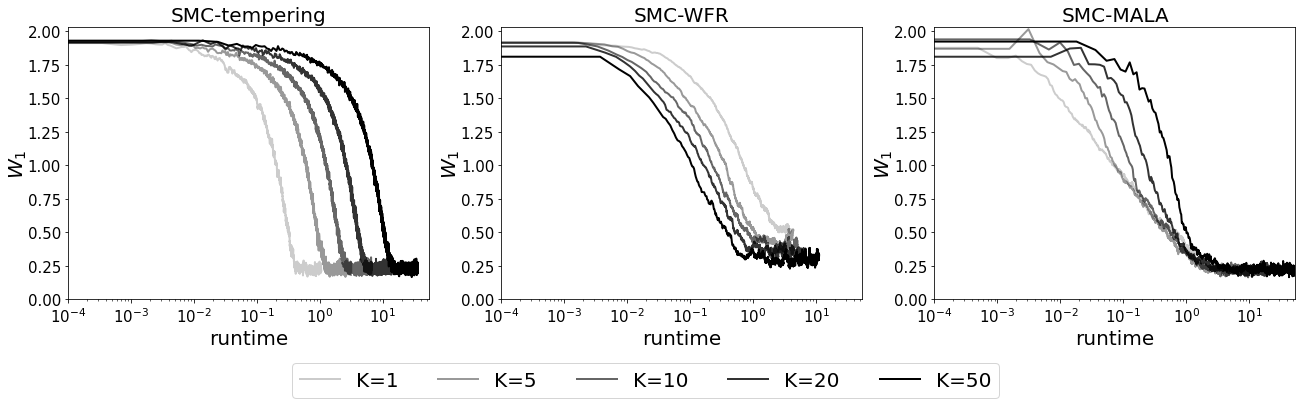

In [27]:
plt.figure(figsize = (22,5))

alphas = np.array([0.2, 0.4, 0.6, 0.8, 1])
for k in range(Ksize):
    nmcmc = Ks[k]
    xx_fr = avg_runtime[k, 0]/Niter_fr*np.arange(Niter_fr)
    xx_wfr = avg_runtime[k, 1]/Niter*np.arange(Niter)
    xx_smcula = avg_runtime[k, 2]/Niter_smcula*np.arange(Niter_smcula)
    xx_smcmala = avg_runtime[k, 3]/Niter_smcmala*np.arange(Niter_smcmala)
    
    w1_fr_plot = np.mean(np.mean(w1_fr[k, :], axis = 1), axis = 0)
    w1_wfr_plot = np.mean(np.mean(w1_wfr[k, :], axis = 1), axis = 0)
    w1_smcula_plot = np.mean(np.mean(w1_smcula[k, :], axis = 1), axis = 0)
    w1_smcmala_plot = np.mean(np.mean(w1_smcmala[k, :], axis = 1), axis = 0)
    
    plt.subplot(1, 3, 1)
    plt.title('SMC-tempering', fontsize = 20)
    plt.semilogx(xx_fr, w1_fr_plot, label = 'K='+str(nmcmc), lw = 2, c = 'black', alpha = alphas[k])
    plt.xlabel('runtime', fontsize = 20)
    plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    plt.xlim(0.0001, max(np.concatenate([xx_wfr, xx_fr, xx_smcmala]))+0.01) 
    plt.ylim(0, max(np.concatenate([w1_fr_plot, w1_wfr_plot, w1_smcmala_plot]))+0.1) 
    plt.subplot(1, 3, 2)
    plt.title('SMC-WFR', fontsize = 20)
    plt.semilogx(xx_wfr, w1_wfr_plot, label = 'K='+str(nmcmc), lw = 2, c = 'black', alpha = alphas[k])
    plt.xlabel('runtime', fontsize = 20)
    plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    plt.xlim(0.0001, max(np.concatenate([xx_wfr, xx_fr, xx_smcmala]))+0.01) 
    plt.ylim(0, max(np.concatenate([w1_fr_plot, w1_wfr_plot, w1_smcmala_plot]))+0.1) 
    plt.subplot(1, 3, 3)
#     plt.title('SMC-ULA', fontsize = 20)
#     plt.semilogx(xx_smcula, w1_smcula_plot, label = 'K='+str(nmcmc), lw = 2, c = 'black', alpha = alphas[k])
#     plt.xlabel('runtime', fontsize = 20)
#     plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
#     plt.xticks(fontsize=15);
#     plt.yticks(fontsize=15);
#     plt.xlim(0.0001, max(np.concatenate([xx_wfr, xx_fr, xx_smcula, xx_smcmala]))+0.01) 
#     plt.ylim(0, max(np.concatenate([w1_fr_plot, w1_wfr_plot, w1_smcula_plot, w1_smcmala_plot]))+0.1) 
#     plt.subplot(2, 2, 4)
    plt.title('SMC-MALA', fontsize = 20)
    plt.semilogx(xx_smcmala, w1_smcmala_plot, label = 'K='+str(nmcmc), lw = 2, c = 'black', alpha = alphas[k])
    plt.xlabel('runtime', fontsize = 20)
    plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    plt.xlim(0.0001, max(np.concatenate([xx_wfr, xx_fr, xx_smcmala]))+0.01)
    plt.ylim(0, max(np.concatenate([w1_fr_plot, w1_wfr_plot, w1_smcmala_plot]))+0.1) 
    plt.legend(loc = 'lower center', bbox_to_anchor=(-.8, -0.4), ncol = 5, fontsize = 20)

# plt.savefig('banana_K_runtime.pdf', bbox_inches="tight")

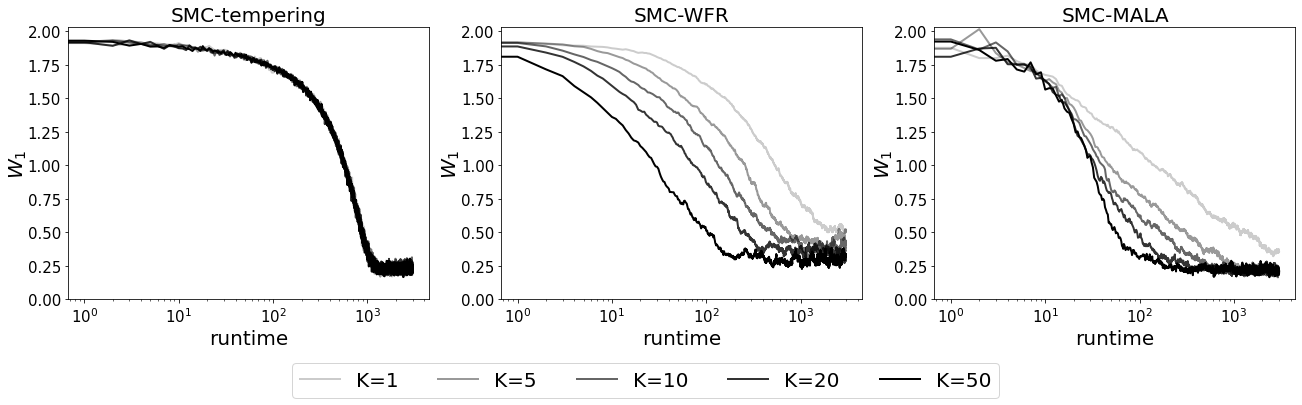

In [25]:
plt.figure(figsize = (22,5))

alphas = np.array([0.2, 0.4, 0.6, 0.8, 1])
for k in range(Ksize):
    nmcmc = Ks[k]
    xx_fr = avg_runtime[k, 0]/Niter_fr*np.arange(Niter_fr)
    xx_wfr = avg_runtime[k, 1]/Niter*np.arange(Niter)
    xx_smcula = avg_runtime[k, 2]/Niter_smcula*np.arange(Niter_smcula)
    xx_smcmala = avg_runtime[k, 3]/Niter_smcmala*np.arange(Niter_smcmala)
    
    w1_fr_plot = np.mean(np.mean(w1_fr[k, :], axis = 1), axis = 0)
    w1_wfr_plot = np.mean(np.mean(w1_wfr[k, :], axis = 1), axis = 0)
    w1_smcula_plot = np.mean(np.mean(w1_smcula[k, :], axis = 1), axis = 0)
    w1_smcmala_plot = np.mean(np.mean(w1_smcmala[k, :], axis = 1), axis = 0)
    
    plt.subplot(1, 3, 1)
    plt.title('SMC-tempering', fontsize = 20)
    plt.semilogx(w1_fr_plot, label = 'K='+str(nmcmc), lw = 2, c = 'black', alpha = alphas[k])
    plt.xlabel('runtime', fontsize = 20)
    plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    plt.ylim(0, max(np.concatenate([w1_fr_plot, w1_wfr_plot, w1_smcmala_plot]))+0.1) 
    plt.subplot(1, 3, 2)
    plt.title('SMC-WFR', fontsize = 20)
    plt.semilogx(w1_wfr_plot, label = 'K='+str(nmcmc), lw = 2, c = 'black', alpha = alphas[k])
    plt.xlabel('runtime', fontsize = 20)
    plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    plt.ylim(0, max(np.concatenate([w1_fr_plot, w1_wfr_plot, w1_smcmala_plot]))+0.1) 
    plt.subplot(1, 3, 3)
    plt.title('SMC-MALA', fontsize = 20)
    plt.semilogx(w1_smcmala_plot, label = 'K='+str(nmcmc), lw = 2, c = 'black', alpha = alphas[k])
    plt.xlabel('runtime', fontsize = 20)
    plt.ylabel('$W_1$', fontsize = 20, labelpad=-1)
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    plt.ylim(0, max(np.concatenate([w1_fr_plot, w1_wfr_plot, w1_smcmala_plot]))+0.1) 
    plt.legend(loc = 'lower center', bbox_to_anchor=(-.8, -0.4), ncol = 5, fontsize = 20)

# plt.savefig('banana_K_iter.pdf', bbox_inches="tight")